<a href="https://colab.research.google.com/github/mjalalimanesh/sparse-dot-deep-learning/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#### Add Google Drive and change path  

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/DL_imaging/ANN_Colab_2"
import os
os.chdir("/content/drive/My Drive/DL_imaging/ANN_Colab_2")

### Import required Libraries

In [3]:
import tensorflow as tf
print('TF Version : ', tf.__version__)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd	
from sklearn import preprocessing

TF Version :  2.3.0


### Read Training, Validation and Test Data

In [7]:
from read_preprocess_data import read_preprocess_data

x_train, y_train, x_val, y_val, x_test, y_test, stand = read_preprocess_data(subtract_homogen=True,  \
                                                                             is_standard_scalar_input=True
                                                                             , noise_level=0.0)

In [8]:
print('input training data shape : ', x_train.shape)
print('output training data shape', y_train.shape)
print('-'*40)
print('input val data shape : ', x_val.shape)
print('output val data shape : ', y_val.shape)
print('-'*40)
print('input test data shape : ', x_test.shape)
print('output test data shape : ', y_test.shape)


input training data shape :  (28900, 29)
output training data shape (28900, 4096)
----------------------------------------
input val data shape :  (1000, 29)
output val data shape :  (1000, 4096)
----------------------------------------
input test data shape :  (100, 29)
output test data shape :  (100, 4096)


Plot several samples

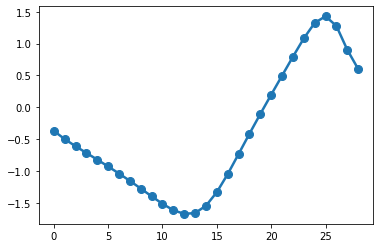

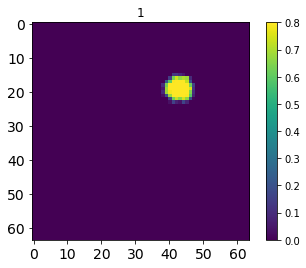

In [16]:
grd = (64,64)
point = np.arange(0,36).reshape((1,36))
for i in range(1,2):
    plt.figure(figsize=(6,4))
    x = x_test[i:i+1,:]
    plt.plot(x.ravel(), '-o', linewidth=2.5, markersize=8)
    #plt.axis('off')
    y_test_ = np.zeros((64*64))
    y_test_ = y_test[i:i+1,:].ravel() 
    y = y_test_.reshape(grd, order='F')
    plt.figure()
    plt.imshow(y)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #axis.off()
    plt.colorbar()
    plt.title(str(i) )

    

Read Simulation homogenous data and do same preprocessing as other data

In [13]:
from read_preprocess_data import one_fit

Homo_input = (pd.read_csv("homo.txt", sep=',', header = None).values)
Homo_input = (Homo_input.T[:,:] / np.max(Homo_input[:,:]))
Homo_input = Homo_input * 0.9111 
homo = np.log(one_fit(Homo_input))


### Read And Compile Model
Set Neural Network architecture and Optimization details

There are several models available in network_architectures file.

In [14]:
from network_architectures import mlp, conv2d_FC, conv1d_FC, FC_conv2d, resnet, one_d_conv, dense_1dconv
#n_neurons = [128,128, 128, 256, 256, 512, 1024]
#activations = ["tanh","relu", "relu", "relu", "relu", "relu", "tanh"]
#model = mlp(n_hidden_layers=7, n_neurons = n_neurons, activations=activations)
#model = tf.keras.models.load_model('oldies/old_models/model2_exp_37.h5')
#model = tf.keras.models.load_model('modelbeta.h5', compile=False)
#model = FC_conv2d()
model = one_d_conv()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 29, 1)             0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 32, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 128)           4224      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 128)           5

#### Compile model
model is tested with several optimizers and loss functions

In [ ]:
# define optimizer
#my_optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
#from network_architectures import costum_objective
#my_optimizer = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#my_optimizer = tf.keras.optimizers.RMSprop(lr=10, rho=0.9, epsilon=None, decay=0.0)
my_optimizer = tf.keras.optimizers.Adam(lr=0.001)
# define loss function
def custom_objective(y_true, y_pred):
	"""
	costum objective function
	balanced sum of mse and mae
	"""
	mse_loss= tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=-1)
	mae_loss = tf.keras.backend.mean(tf.keras.backend.abs(y_pred - y_true), axis=-1)
	loss = mse_loss +  1.2 * mae_loss 
	return loss

#msle = tf.keras.losses.MeanSquaredLogarithmicError()
#huber = tf.keras.losses.Huber()
#l = tf.keras.losses.LogCosh()
model.compile(optimizer= my_optimizer , loss=custom_objective, metrics=['mean_absolute_error', 'mean_squared_error'])

### Fit Model

In [ ]:
# create a learning rate scheduler callback
# 20-27-35-40
# 12 18 25 35
# sim 35 - 55 - 70 - 85
def scheduler(epoch):
    if epoch <35:
        return 0.001
    elif epoch < 55:
        return 0.0003
    elif epoch < 70:
        return 0.0001
    elif epoch < 85:
        return 0.00003
    else:
        return 0.00001
LRS = tf.keras.callbacks.LearningRateScheduler(schedule= scheduler, verbose=0)
# EarlyStopping call back to stop training when overfitting
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-9, \
                                      patience=5, verbose=2, mode='min', restore_best_weights=True)

# fit the model
hist = model.fit( x_train, y_train, batch_size =128, validation_data = ( x_val, y_val) , \
                 epochs =150, verbose=2, callbacks=[LRS, ES], initial_epoch=85)


In [ ]:
model.save('model2.h5')